# Gene Promoter Prediction

We have a collection of DNA sequences, labeled as to whether each sequence contains promoter regions or not, and we need to train a model to classify and make predictions for sequences it has never seen before.

We will explore models for classification based on statistical features, hexamers (k-mers with k=6), sequential hexamers, and the original sequential data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import warnings

warnings.filterwarnings('ignore')

results = {} #dictionary to store accuracy and f1-score of models

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data -d data

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'promoters.data' (UTF-8) -> 'promoters.data' (UTF-8)
--2022-04-04 16:18:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Caching archive.ics.uci.edu => 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
Created socket 5.
Releasing 0x000055a0563ccaa0 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 5 to SSL handle 0x000055a0563f0000
certificate:
  subject: CN=*.ics.uci.edu,OU=Donald Bren School of Information and Computer Sciences,O=University of California\\, Irvine,L=Irvine,ST=California,C=US
  issuer:  CN=InCommon RSA Server CA,OU=InCommon,O=Internet2,L=Ann Arbor,ST=MI,C=US
X509 certificate successfully verified and matches

In [7]:
columns = ['class','id','seq']
df = pd.read_csv('/content/promoters.data',names=columns)
df.head(2)

,class,id,seq
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...


Many sequences start with '\t' or '\t\t'. We remove these redundant characters

In [8]:
#clean sequences
def clean(s):
    return s.replace('\t','')
    
df['seq'] = df['seq'].apply(clean)

df.head(2)

,class,id,seq
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...


## Exploratory Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   106 non-null    object
 1   id      106 non-null    object
 2   seq     106 non-null    object
dtypes: object(3)
memory usage: 2.6+ KB


sequence length value counts: 57    106
Name: lengths, dtype: int64


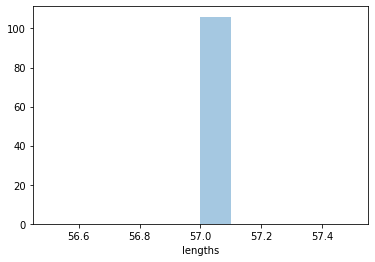

In [10]:
#sequence lengths
lengths = []
for s in df['seq']: lengths.append(len(s))
df['lengths'] = lengths
print('sequence length value counts:', df['lengths'].value_counts())

sns.distplot(df['lengths'],kde=False);

number of classes: 2
class: +    number of values: 53
class: -    number of values: 53



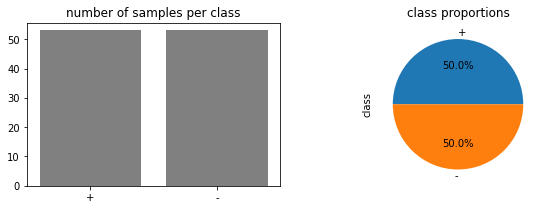

In [11]:
#class proportions
n_classes = df['class'].nunique()
print('number of classes:', n_classes)
label_counts = df['class'].value_counts()
 
for c,v in zip(label_counts.index, label_counts.values):
    print('class: {}    number of values: {}'.format(c,v))    

print('')
plt.figure(figsize=(10,3));
plt.subplot(1,2,1);
sns.barplot(x= label_counts.index, y=label_counts.values, 
            color='Grey');
plt.title('number of samples per class');
plt.subplot(1,2,2);
df['class'].value_counts().plot(kind='pie',autopct='%.1f%%');
plt.title('class proportions');

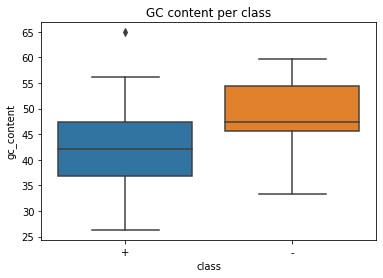

In [12]:
# GC content boxplots

def gc_content (s):
    l = len(s)
    lgc = 0
    for c in s.lower():
        if c in ['c','g']: lgc += 1
    return lgc/l*100

df['gc_content'] = df['seq'].apply(gc_content)

sns.boxplot(x='class',y='gc_content',data=df);
plt.title('GC content per class');

On the above graph we see that the two classes have quite distinct GC contents. Later we will try classifying samples based on GC content alone.

In [13]:
#generate list of codons
alphabet = ['a','c','g','t']
codon_list = []
for a in alphabet:
    for b in alphabet:
        for c in alphabet:
            codon_list.append(a+b+c)

In [14]:
#create dataframe of which and how many codons each sample has

freqs = []

for codon in codon_list:
    for s in df['seq']:
        freqs.append(s.count(codon))
        
freqs = np.reshape(np.array(freqs),(df.shape[0],len(codon_list)))
cf = pd.DataFrame(data=freqs,columns=codon_list,dtype='int')
cf['label']=df['class']
cf.head(2)

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt,label
0,0,0,0,1,2,3,0,1,2,1,...,2,0,0,0,0,0,0,1,0,+
1,0,0,0,0,0,0,0,1,0,1,...,1,1,0,0,2,2,0,1,2,+


In [16]:
#create dataframe with normalized codon frequency for each class
#will use to make plot

positives = []
negatives = []

for codon in codon_list:
    positives.append(cf[cf['label'] == '+'][codon].sum()/106)
    negatives.append(cf[cf['label'] == '-'][codon].sum()/106)

codon_freqs = pd.DataFrame([])
for c,n,p in zip(codon_list,negatives,positives): codon_freqs[c]=pd.Series([n,p])
codon_freqs.head()

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
0,0.396226,0.452830,0.396226,0.405660,0.528302,0.433962,0.405660,0.462264,0.367925,0.594340,...,0.462264,0.45283,0.443396,0.462264,0.537736,0.471698,0.377358,0.358491,0.349057,0.386792
1,0.386792,0.424528,0.405660,0.349057,0.415094,0.367925,0.339623,0.433962,0.396226,0.377358,...,0.339623,0.40566,0.396226,0.471698,0.415094,0.405660,0.481132,0.443396,0.330189,0.424528


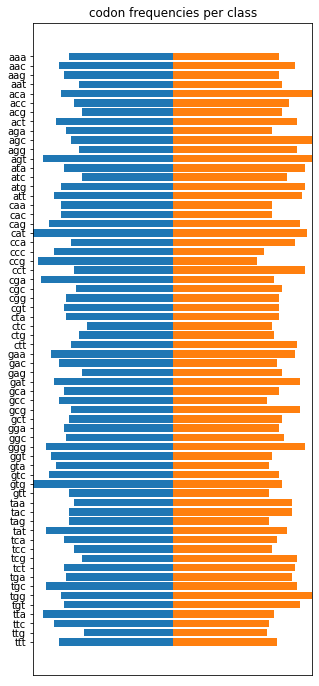

In [17]:
# generate plot with codon frequencies for each class

width = np.sum((cf.groupby(by='label').sum()/106).values,axis=0).max()
fig,ax=plt.subplots(figsize=(5,12));
ax.invert_yaxis();
ax.xaxis.set_visible(False);
ax.set_xlim(0,width);
ax.barh(codon_list,(cf.groupby(by='label').sum()/106).iloc[0],
       left=width/2-(cf.groupby(by='label').sum()/106).iloc[0]);
ax.barh(codon_list,(cf.groupby(by='label').sum()/106).iloc[1],
      left=width/2);
plt.title('codon frequencies per class');

# Classification on Statistical Features

We will start experimentation by trying out the oldschool technique of classifying based on extracted statistical features.

First, we will only take account of GC content. After trying different threshold value, we found the best value to be 43. Sequences with GC content higher than or equal to 43 will be classified as positive, and the rest as negative. That alone will give us an accuracy of 71.69%, as seen in the cell below

accuracy: 0.7169811320754716
f1-score: 0.7580645161290323


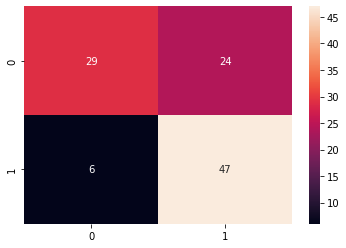

In [18]:
#classify on gc_content

from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
y = lbl.fit_transform(df['class'].values)

#classify samples on whether gc_content is aboveor below 43%
ccs = []
for i in df['gc_content']:
    if i < 43: ccs.append(0)
    else: ccs.append(1)
    
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
print('accuracy:', accuracy_score(y,ccs))
print('f1-score:', f1_score(y,ccs))
sns.heatmap(confusion_matrix(y,ccs),annot=True,fmt='1d');

results['GC_content->thresholding'] = [accuracy_score(y,ccs), f1_score(y,ccs)]

Now we will combine GC content with codon frequencies. We will integrate them into a dataset and train Logistic Regression and Random Forest models on the data.

#### Data Preparation

In [19]:
# combine codon frequencies and gc_content into a dataframe
cf['gc_content'] = df['gc_content']
cf.head(3)

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt,label,gc_content
0,0,0,0,1,2,3,0,1,2,1,...,0,0,0,0,0,0,1,0,+,47.368421
1,0,0,0,0,0,0,0,1,0,1,...,1,0,0,2,2,0,1,2,+,47.368421
2,2,2,1,1,0,0,2,1,1,2,...,3,0,1,0,1,3,2,1,+,40.350877


In [20]:
#libraries and data needed
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


lab = LabelEncoder()
y = lab.fit_transform(cf['label'].values)

x = cf.drop(columns='label').values

x_tr,x_ts, y_tr, y_ts = train_test_split(x,y,test_size=0.1)

#### Logistic Regression on Statistical Features

accuracy: 0.8181818181818182
f1-score: 0.6666666666666666


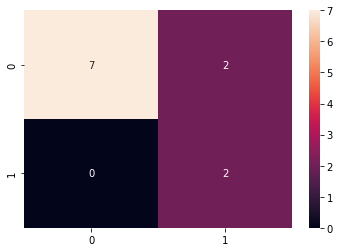

In [21]:
lr = LogisticRegression()
lr.fit(x_tr,y_tr)
pred=lr.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Statistical features -> Logistic Regression'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

#### Random Forest on Statistical Features

accuracy: 0.5454545454545454
f1-score: 0.4444444444444445


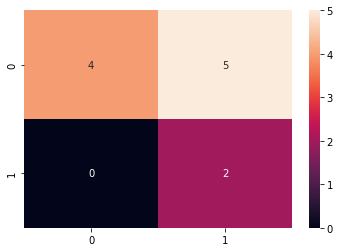

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=2000,max_depth=7)
rf.fit(x_tr,y_tr)
pred = rf.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Statistical features -> Random Forest'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

## Classification on Hexamers

Classification on k-mers is also widely used. Here, we will use hexamers (k=6). We will make a list of all the possible hexamers of the characters [a,c,g,t] and we will encode each sequence as a vector of length = n_hexamers where, for each position in the vector, we will assign a value of 1 if the sequence contains that particular hexamer, 0 otherwise.

Notice that this method yields the highest performance on this particular dataset, but this will not always be the case. Experimentation with other methods is necessary, hence, we will later demonstrate classification on two other data representations.

#### Hexamer analysis

In [23]:
#hexamers
alphabet = ['a','c','g','t']
exa_list = []
for a in alphabet:
    for b in alphabet:
        for c in alphabet:
            for d in alphabet:
                for e in alphabet:
                    for f in alphabet:  exa_list.append(a+b+c+d+e+f)

#create arrays for each hexamer, len = n_samples
#if sample x contains hexamer h, then h[x]=1, else 0
exarray = np.zeros((df.shape[0],len(exa_list)),dtype='int')
for i,s in enumerate(df['seq']):
    for j,ex in enumerate(exa_list):
        if ex in s: exarray[i,j] = 1

#merge arrays into a dataframe
examers = pd.DataFrame([])
for i,ex in enumerate(exa_list):
    examers[ex] = pd.Series(exarray[:,i])
    
examers.head(2)

,aaaaaa,aaaaac,aaaaag,aaaaat,aaaaca,aaaacc,aaaacg,aaaact,aaaaga,aaaagc,...,ttttcg,ttttct,ttttga,ttttgc,ttttgg,ttttgt,ttttta,tttttc,tttttg,tttttt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


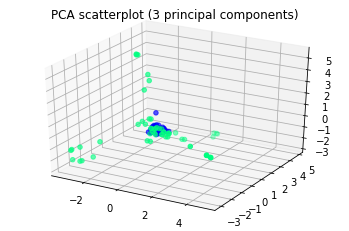

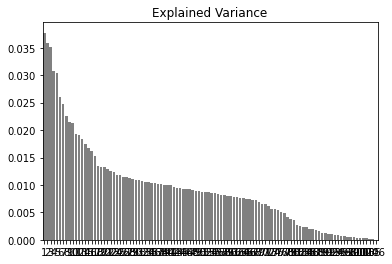

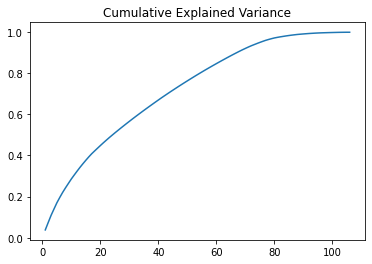

In [24]:
#visualize dataframe with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


enc = LabelEncoder()
y= enc.fit_transform(df['class'].values)

pca = PCA()
ex_pca = pca.fit_transform(examers.values)

plt.figure();
ax = plt.axes(projection='3d');
ax.scatter(ex_pca[:,0], ex_pca[:,1], ex_pca[:,2], c=y, cmap='winter');
plt.title('PCA scatterplot (3 principal components)');

plt.figure();
var_index = np.arange(pca.explained_variance_.shape[0])+1
sns.barplot(var_index,pca.explained_variance_ratio_,color='gray');
plt.title('Explained Variance');

plt.figure();
sns.lineplot(var_index, pca.explained_variance_ratio_.cumsum());
plt.title('Cumulative Explained Variance');

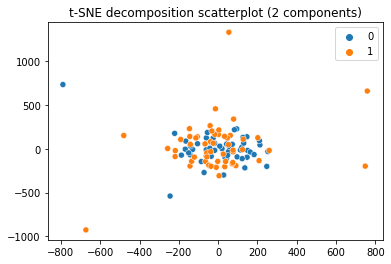

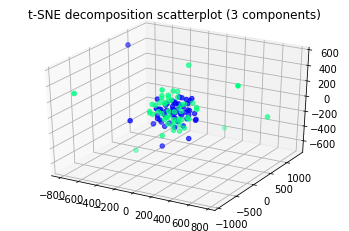

In [25]:
#visualize dataframe with t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=33)
ts_ex = tsne.fit_transform(examers.values)

sns.scatterplot(ts_ex[:,0], ts_ex[:,1],hue=y);
plt.title('t-SNE decomposition scatterplot (2 components)');
plt.figure();
ax = plt.axes(projection='3d');
ax.scatter(ts_ex[:,0], ts_ex[:,1], ts_ex[:,2], c=y, cmap='winter');
plt.title('t-SNE decomposition scatterplot (3 components)');

#### Logistic Regression on Hexamers

accuracy: 0.9090909090909091
f1-score: 0.923076923076923


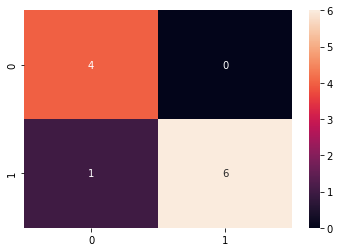

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_tr,x_ts,y_tr,y_ts = train_test_split(examers.values, y, test_size=0.1,random_state=33)

lr=LogisticRegression()
lr.fit(x_tr,y_tr)
pred=lr.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Hexamers -> Logistic Regression'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

#### Logistic Regression on PCA-decomposed Hexamers

accuracy: 0.9090909090909091
f1-score: 0.9333333333333333


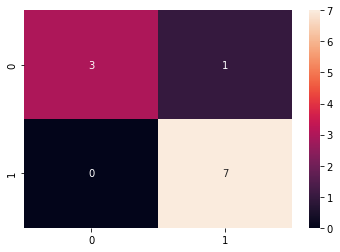

In [27]:
x_pca = ex_pca[:,:40]
x_pca_tr,x_pca_ts,y_tr,y_ts = train_test_split(x_pca, y, test_size=0.1,random_state=33)
lr1=LogisticRegression()
lr1.fit(x_pca_tr,y_tr)
pred=lr1.predict(x_pca_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['PCA-decomposed Hexamers -> Logistic Regression'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

#### Random Forest on Hexamers

accuracy: 0.9090909090909091
f1-score: 0.923076923076923


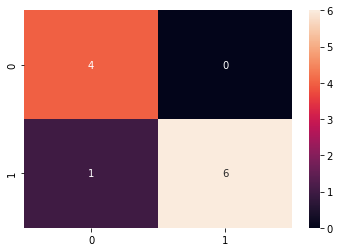

In [28]:
rf = RandomForestClassifier(n_estimators=2000)
rf.fit(x_tr,y_tr)
pred = rf.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Hexamers -> Random Forest'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

## Classification of Embedded Hexamers

Now we will convert the nucleotide sequences into sequences of hexamers using a 'sliding window', and we will encode these using a keras Embedding layer, then train deep learning models.

In [29]:
#generate matrix with rows=n_samples, columns=len(samples)-6
#hexamers are stored sequentially
for i,seq in enumerate(df['seq']):
    temp=[]
    for j in range(len(seq)-6):
        temp.append(seq[j:j+6])
    if i == 0: hexes = np.array(temp)
    else: hexes = np.vstack((hexes,temp))
        
hexes.shape

(106, 51)

In [30]:
hexes[0]

array(['tactag', 'actagc', 'ctagca', 'tagcaa', 'agcaat', 'gcaata',
       'caatac', 'aatacg', 'atacgc', 'tacgct', 'acgctt', 'cgcttg',
       'gcttgc', 'cttgcg', 'ttgcgt', 'tgcgtt', 'gcgttc', 'cgttcg',
       'gttcgg', 'ttcggt', 'tcggtg', 'cggtgg', 'ggtggt', 'gtggtt',
       'tggtta', 'ggttaa', 'gttaag', 'ttaagt', 'taagta', 'aagtat',
       'agtatg', 'gtatgt', 'tatgta', 'atgtat', 'tgtata', 'gtataa',
       'tataat', 'ataatg', 'taatgc', 'aatgcg', 'atgcgc', 'tgcgcg',
       'gcgcgg', 'cgcggg', 'gcgggc', 'cgggct', 'gggctt', 'ggcttg',
       'gcttgt', 'cttgtc', 'ttgtcg'], dtype='<U6')

In [31]:
# merge each row into a single item, hexamers divided by ' '.
# rows now form a list of len=n_samples
hexamers = [' '.join(hexs) for hexs in hexes]
hexamers[0]

'tactag actagc ctagca tagcaa agcaat gcaata caatac aatacg atacgc tacgct acgctt cgcttg gcttgc cttgcg ttgcgt tgcgtt gcgttc cgttcg gttcgg ttcggt tcggtg cggtgg ggtggt gtggtt tggtta ggttaa gttaag ttaagt taagta aagtat agtatg gtatgt tatgta atgtat tgtata gtataa tataat ataatg taatgc aatgcg atgcgc tgcgcg gcgcgg cgcggg gcgggc cgggct gggctt ggcttg gcttgt cttgtc ttgtcg'

In [32]:
#tokenize data, prepare train-test set
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tknizer = Tokenizer()
tknizer.fit_on_texts(hexamers)
tokened = np.array(tknizer.texts_to_sequences(hexamers))
index_length = len(tknizer.word_index) + 1
print('tokenizer index length:', index_length)

lab = LabelEncoder()
y = lab.fit_transform(df['class'].values)

x_tr, x_ts, y_tr, y_ts = train_test_split(tokened,y,
                                         test_size=0.1,random_state=33)

tokenizer index length: 2312


#### Bidirectional LSTM on Sequential Embedded Hexamers

In [44]:
import tensorflow as tf
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

model = models.Sequential()
model.add(layers.Embedding(index_length,10))
model.add(layers.Bidirectional(layers.LSTM(10)))
model.add(layers.Dense(15,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['acc'])

model.fit(x_tr,y_tr,epochs=10,verbose=1,validation_split=0.1)

Epoch 1/50
3/3 [==============================] - 8s 665ms/step - loss: 0.6931 - acc: 0.4941 - val_loss: 0.6958 - val_acc: 0.3000
Epoch 2/50
3/3 [==============================] - 0s 41ms/step - loss: 0.6896 - acc: 0.5882 - val_loss: 0.6969 - val_acc: 0.3000
Epoch 3/50
3/3 [==============================] - 0s 31ms/step - loss: 0.6842 - acc: 0.5765 - val_loss: 0.6943 - val_acc: 0.4000
Epoch 4/50
3/3 [==============================] - 0s 29ms/step - loss: 0.6748 - acc: 0.9412 - val_loss: 0.6909 - val_acc: 0.7000
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.6612 - acc: 0.9882 - val_loss: 0.6823 - val_acc: 0.8000
Epoch 6/50
3/3 [==============================] - 0s 31ms/step - loss: 0.6430 - acc: 1.0000 - val_loss: 0.6725 - val_acc: 0.9000
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.6215 - acc: 1.0000 - val_loss: 0.6543 - val_acc: 0.8000
Epoch 8/50
3/3 [==============================] - 0s 27ms/step - loss: 0.5958 - acc: 1.0000 - va

accuracy: 0.9090909090909091
f1-score: 0.923076923076923


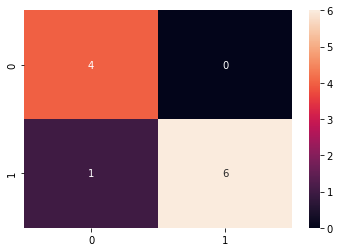

In [45]:
preds = []
for p in model.predict(x_ts):
    if p<0.5: preds.append(0)
    else: preds.append(1)

print('accuracy:', accuracy_score(y_ts,preds))
print('f1-score:', f1_score(y_ts,preds))
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d');

results['Sequential Embedded Hexamers -> Bidirectional LSTM'] = [accuracy_score(y_ts,preds), f1_score(y_ts,preds)]

#### CNN on Sequential Embedded Hexamers

In [46]:
model = models.Sequential()
model.add(layers.Embedding(index_length,10))
model.add(layers.Conv1D(16,10,activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

model.fit(x_tr,y_tr,epochs=10,verbose=0,validation_split=0.1)

accuracy: 0.9090909090909091
f1-score: 0.923076923076923


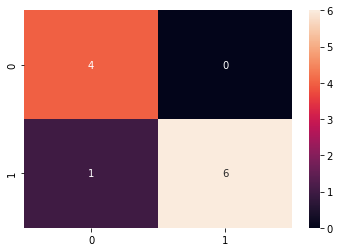

In [47]:
preds = []
for p in model.predict(x_ts):
    if p<0.5: preds.append(0)
    else: preds.append(1)

print('accuracy:', accuracy_score(y_ts,preds))
print('f1-score:', f1_score(y_ts,preds))
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d');

results['Sequential Embedded Hexamers -> CNN'] = [accuracy_score(y_ts,preds), f1_score(y_ts,preds)]

## Classification on sequential data

Lastly, we will train models on the nucleotide sequences themselves.


We try traditional machine learning models, namely Logistic Regression and Random Forest on ordinally encoded sequences, and then deep learning models on one-hot encoded sequences.

### Ordinal-encoded Sequences

In [48]:
#ordinal encoding
x = np.zeros((106,57))
for i,s in enumerate(df['seq']):
    for j,c in enumerate(s):
        if c == 'a': x[i,j] = 0.25
        elif c == 'c': x[i,j] = 0.50
        elif c == 'g': x[i,j] = 0.75
        else: x[i,j] = 1
            
x.shape,x[0,:4]

((106, 57), array([1.  , 0.25, 0.5 , 1.  ]))

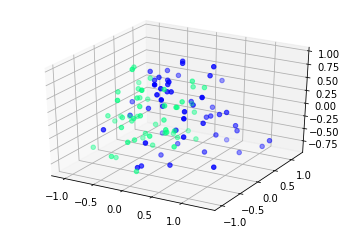

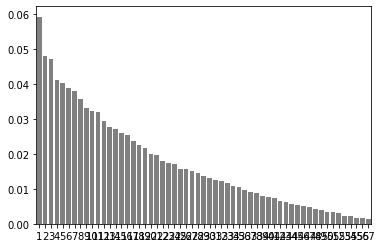

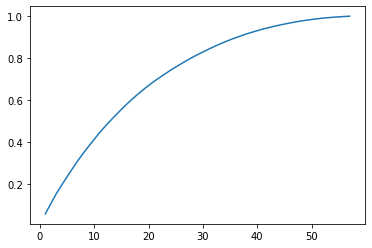

In [49]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(x)

plt.figure();
ax = plt.axes(projection='3d');
ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=y, cmap='winter');

plt.figure();
var_index = np.arange(pca.explained_variance_.shape[0])+1
sns.barplot(var_index,pca.explained_variance_ratio_,color='gray');

plt.figure();
sns.lineplot(var_index, pca.explained_variance_ratio_.cumsum());

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

enc = LabelEncoder()
y= enc.fit_transform(df['class'].values)

x_tr,x_ts, y_tr, y_ts = train_test_split(x,y,test_size=0.2,
                                         random_state=42)
x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape

((84, 57), (84,), (22, 57), (22,))

#### Logistic Regression on sequential data

accuracy: 0.7727272727272727
f1-score: 0.7368421052631579


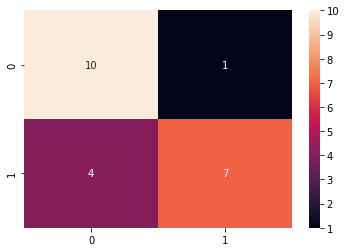

In [51]:
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
pred = logreg.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Sequential Ordinal_Encoded -> Logistic Regression'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

#### Random Forest on sequential data

accuracy: 0.8636363636363636
f1-score: 0.8571428571428572


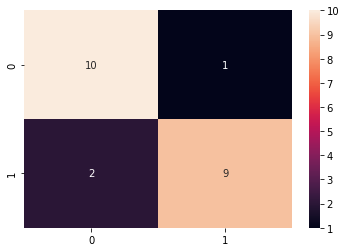

In [52]:
rf = RandomForestClassifier(n_estimators=2000)
rf.fit(x_tr,y_tr)
pred = rf.predict(x_ts)
print('accuracy:', accuracy_score(y_ts,pred))
print('f1-score:', f1_score(y_ts,pred))
sns.heatmap(confusion_matrix(y_ts,pred),annot=True,fmt='1d');

results['Sequential Ordinal_Encoded -> Random Forest'] = [accuracy_score(y_ts,pred), f1_score(y_ts,pred)]

### OneHot-encoded Sequences

In [53]:
#onehot encoding
x_onehot = np.zeros((106,4,57),dtype='int')
for i,s in enumerate(df['seq']):
    for j,c in enumerate(s):
        if c == 'a': x_onehot[i,0,j] = 1
        elif c == 'c': x_onehot[i,1,j] = 1
        elif c == 'g': x_onehot[i,2,j] = 1
        else: x_onehot[i,3,j] = 1
            
            
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

enc = LabelEncoder()
y= enc.fit_transform(df['class'].values)

x_tr,x_ts, y_tr, y_ts = train_test_split(x_onehot,y,test_size=0.2,
                                         random_state=42)
x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape

((84, 4, 57), (84,), (22, 4, 57), (22,))

#### Convolutional Neural Network on sequential data

In [57]:
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [55]:
model = models.Sequential()
model.add(layers.Conv1D(256,12,activation='relu',
                        input_shape=(x_tr.shape[1],x_tr.shape[2]),
                        padding='same'))
model.add(layers.Dropout(0.1))
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.MaxPool1D(10,padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])


stop = EarlyStopping(patience=4,verbose=1)
model.fit(x_tr,y_tr,epochs=15, validation_split=0.1,verbose=2,callbacks=[stop])

Epoch 1/15
3/3 - 1s - loss: 0.6882 - acc: 0.5333 - val_loss: 0.6704 - val_acc: 0.4444 - 696ms/epoch - 232ms/step
Epoch 2/15
3/3 - 0s - loss: 0.5153 - acc: 0.8800 - val_loss: 0.5876 - val_acc: 0.7778 - 32ms/epoch - 11ms/step
Epoch 3/15
3/3 - 0s - loss: 0.3555 - acc: 1.0000 - val_loss: 0.5372 - val_acc: 0.7778 - 38ms/epoch - 13ms/step
Epoch 4/15
3/3 - 0s - loss: 0.2434 - acc: 1.0000 - val_loss: 0.4988 - val_acc: 0.7778 - 28ms/epoch - 9ms/step
Epoch 5/15
3/3 - 0s - loss: 0.1448 - acc: 1.0000 - val_loss: 0.4674 - val_acc: 0.7778 - 29ms/epoch - 10ms/step
Epoch 6/15
3/3 - 0s - loss: 0.0879 - acc: 1.0000 - val_loss: 0.4427 - val_acc: 0.7778 - 47ms/epoch - 16ms/step
Epoch 7/15
3/3 - 0s - loss: 0.0489 - acc: 1.0000 - val_loss: 0.4330 - val_acc: 0.7778 - 30ms/epoch - 10ms/step
Epoch 8/15
3/3 - 0s - loss: 0.0286 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.7778 - 27ms/epoch - 9ms/step
Epoch 9/15
3/3 - 0s - loss: 0.0160 - acc: 1.0000 - val_loss: 0.4195 - val_acc: 0.7778 - 31ms/epoch - 10ms/step
E

accuracy: 0.8636363636363636
f1-score: 0.8421052631578948


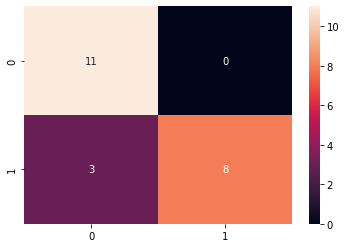

In [58]:
preds = []
for p in model.predict(x_ts):
    if p<0.5: preds.append(0)
    else: preds.append(1)

print('accuracy:', accuracy_score(y_ts,preds))
print('f1-score:', f1_score(y_ts,preds))
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d');

results['One-hot Sequential  -> CNN'] = [accuracy_score(y_ts,preds), f1_score(y_ts,preds)]

#### Recurent Neural Network (Bidirectional LSTM) on sequential data

In [69]:
from tensorflow.keras.optimizers import RMSprop
rnn = models.Sequential()
rnn.add(layers.Bidirectional(layers.LSTM(50,return_sequences=True),
        input_shape=(x_tr.shape[2],x_tr.shape[1])))
rnn.add(layers.Bidirectional(layers.LSTM(50,return_sequences=True,recurrent_dropout=0.1)))
rnn.add(layers.Bidirectional(layers.LSTM(50)))
rnn.add(layers.Dense(64,activation='relu'))
rnn.add(layers.Dense(1,activation='sigmoid'))

rnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_23 (Bidirecti  (None, 57, 100)          22000     
 onal)                                                           
                                                                 
 bidirectional_24 (Bidirecti  (None, 57, 100)          60400     
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 100)              60400     
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 64)                6464      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                     

In [71]:
rnn.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['acc'])
rnn.fit(np.swapaxes(x_tr,2,1),y_tr, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
3/3 [==============================] - 15s 1s/step - loss: 0.5441 - acc: 0.7067 - val_loss: 0.5795 - val_acc: 0.6667
Epoch 2/10
3/3 [==============================] - 1s 408ms/step - loss: 0.4082 - acc: 0.8400 - val_loss: 0.8308 - val_acc: 0.5556
Epoch 3/10
3/3 [==============================] - 1s 367ms/step - loss: 0.4172 - acc: 0.8133 - val_loss: 0.4614 - val_acc: 0.7778
Epoch 4/10
3/3 [==============================] - 1s 361ms/step - loss: 0.3880 - acc: 0.8400 - val_loss: 0.4995 - val_acc: 0.6667
Epoch 5/10
3/3 [==============================] - 1s 354ms/step - loss: 0.3728 - acc: 0.8267 - val_loss: 0.5097 - val_acc: 0.7778
Epoch 6/10
3/3 [==============================] - 1s 371ms/step - loss: 0.3467 - acc: 0.8800 - val_loss: 0.4919 - val_acc: 0.7778
Epoch 7/10
3/3 [==============================] - 1s 370ms/step - loss: 0.3404 - acc: 0.8800 - val_loss: 0.5093 - val_acc: 0.7778
Epoch 8/10
3/3 [==============================] - 1s 435ms/step - loss: 0.3155 - acc: 0.8667

accuracy: 0.6818181818181818
f1-score: 0.6666666666666666


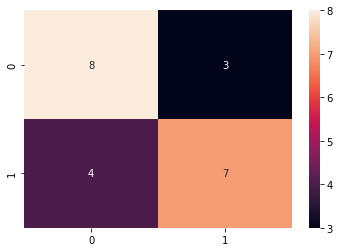

In [72]:
preds = []
for p in rnn.predict(np.swapaxes(x_ts,2,1)):
    if p<0.5: preds.append(0)
    else: preds.append(1)

print('accuracy:', accuracy_score(y_ts,preds))
print('f1-score:', f1_score(y_ts,preds))
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d');

results['One-hot Sequential  -> Bidirectional LSTM'] = [accuracy_score(y_ts,preds), f1_score(y_ts,preds)]

#### CNN/LSTM hybrid on sequential data

In [ ]:
hyb = models.Sequential()
hyb.add(layers.Conv1D(256,12,activation='relu',padding='same',
                      input_shape=(x_tr.shape[1],x_tr.shape[2])))
hyb.add(layers.MaxPool1D(8,padding='same'))
#hyb.add(layers.Flatten())
hyb.add(layers.Bidirectional(layers.LSTM(40)))
hyb.add(layers.Dense(1,activation='sigmoid'))

hyb.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['acc'])
hyb.fit(x_tr,y_tr,epochs=15, validation_split=0.1,verbose=0)

In [ ]:
preds = []
for p in hyb.predict(x_ts):
    if p<0.5: preds.append(0)
    else: preds.append(1)

print('accuracy:', accuracy_score(y_ts,preds))
print('f1-score:', f1_score(y_ts,preds))
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d');

results['One-hot Sequential  -> CNN\Bi-LSTM'] = [accuracy_score(y_ts,preds), f1_score(y_ts,preds)]

# Comparative Results

In [ ]:
#display performance of models in a dataframe 
pd.DataFrame(data=results.values(),index=results.keys(),columns=['accuracy','f1-score'])

In [ ]:
#comparison visualization

#prepare the results-data for barplot
models = list(results.keys())
accuracies = [results[m][0] for m in models]
f1_scores = [results[m][1] for m in models]
ml_models = pd.Series(np.hstack((models,models)))
value = pd.Series(np.hstack((accuracies,f1_scores)))
metric = pd.Series(np.repeat(['accuracy','f1_score'],len(models)))
results_df = pd.DataFrame([])
results_df['representation-model'] = ml_models
results_df['value'] = value
results_df['metric'] = metric

#generate barplot
plt.figure(figsize=(10,5));
sns.barplot(y='representation-model', x='value', data=results_df, 
            hue='metric',palette=['firebrick','lightcoral']);
plt.legend(loc=(1.01,0.8));
plt.tight_layout(True);
plt.title('Model Performance');

#### Note

The particular dataset consisted of very few samples of short sequences. As the number of samples and the length of the sequences increases, classifying based on the sequences, as opposed to k-mers, becomes a better option. Also, with big data, deep learning increasingly supersedes conventional machine learning models.